In [ ]:
import pandas as pd 
import chromadb

import numpy as np

from numpy import dot
from numpy.linalg import norm

import seaborn as sns
from tqdm import tqdm

In [ ]:
meta = pd.read_parquet("meta_beauty_cleaned.parquet")
embedded_data = pd.read_parquet("combined_with_embeddings.parquet")

In [ ]:
merged_data = embedded_data.merge(meta, on="parent_asin", how="inner")

In [ ]:
merged_data["Hair Care"].sum()

35919

In [ ]:
merged_data["Skin Care"].sum()

22308

In [ ]:
merged_data["Makeup"].sum()

13805

In [ ]:
merged_data["Moisturizer"].sum()


4698

In [ ]:
len(merged_data[(merged_data["Makeup"]==1) & (merged_data["Lips"]==1)])
# .sum()

3158

### Summary:
- products all category: 109693
- products hair care: 35919
- products skin care: 22308
- products makeup: 13805
- products lipstick: 3158
- products moisturizer: 4698

In [ ]:
train_path_list = ["filtered_2021_data.parquet", "filtered_2022_data.parquet"]
test_path_list = ["filtered_2023_data.parquet"]

In [ ]:
train_df = pd.concat([pd.read_parquet(x) for x in train_path_list])
test_df = pd.concat([pd.read_parquet(x) for x in test_path_list])

In [ ]:
product_list = set(train_df["parent_asin"].unique().tolist() + test_df["parent_asin"].unique().tolist())

In [ ]:
common_prods = list(product_list.intersection(set(merged_data["parent_asin"].unique().tolist())))

In [ ]:
merged_data  = merged_data[merged_data["parent_asin"].isin(common_prods)]

train_df  = train_df[train_df["parent_asin"].isin(common_prods)]
test_df  = test_df[test_df["parent_asin"].isin(common_prods)]

In [ ]:
train_users = set(train_df["user_id"].unique().tolist())
test_users = set(test_df["user_id"].unique().tolist())

In [ ]:
common_users = train_users.intersection(test_users)

In [ ]:
train_data  = train_df[train_df["user_id"].isin(common_users)]
test_data  = test_df[test_df["user_id"].isin(common_users)]

## Cromadb 

In [ ]:
chroma_client = chromadb.PersistentClient(path="/Users/abhishek/Documents/db")


In [ ]:
collection = chroma_client.get_collection(name="recommendation_sys")

In [ ]:
counts = test_df["user_id"].value_counts()
test_users = counts[counts > 2].index.tolist()

In [ ]:
def calculate_similarity(vector1, vector2, data):

    values = []
    for y in vector1:
        embedding_list = data[data["parent_asin"]==y]["embeddings"]
    
        if len(embedding_list) == 0:
            continue
    
        embedding1 = embedding_list.iloc[0]
    
        for x in vector2:
            embedding_list1 = data[data["parent_asin"]==x]["embeddings"]
        
            if len(embedding_list1) > 0:
                embedding2 = embedding_list1.iloc[0]
                values.append(dot(embedding1, embedding2)/(norm(embedding1)*norm(embedding2)))            

    return np.mean(np.array(values)) if values else 0

In [ ]:
moisturizer_prods = merged_data[merged_data["Moisturizer"]==1]["parent_asin"].unique()

haircare_prods = merged_data[merged_data["Hair Care"]==1]["parent_asin"].unique()
skincare_prods = merged_data[merged_data["Skin Care"]==1]["parent_asin"].unique()
makeup_prods = merged_data[merged_data["Makeup"]==1]["parent_asin"].unique()

lipstick_prods = merged_data[(merged_data["Makeup"]==1) & (merged_data["Lips"]==1)]["parent_asin"].unique()

In [ ]:
train_data_good = train_df[train_df["rating"]>=3]

In [ ]:
sunscreen_prods = merged_data[merged_data["Sunscreens & Tanning Products"]==1]["parent_asin"].unique() 

In [ ]:
result_list = []

product_list = makeup_prods

def get_model_performace(
        user_list: list,
        product_list: list=None,
    ):

    for user in tqdm(user_list):

        _test = test_df[test_df["parent_asin"].isin(product_list)] if product_list else test_df 
        _train = train_data_good[train_data_good["parent_asin"].isin(product_list)] if product_list else train_data_good
        
        purchased = _test[_test["user_id"]==user]["parent_asin"]
        products = _train[train_data_good["user_id"]==user]["parent_asin"].unique()

        if len(products) == 0:
            continue

        if len(purchased) == 0:
            continue
        
        embeddings = merged_data[merged_data["parent_asin"].isin(products)]["embeddings"].values

        if len(embeddings) == 0:
            continue

        embeddings = np.sum(embeddings)
        
        results = collection.query(
            query_embeddings=[embeddings],
            n_results=10,
        )
        
        recommendation_list = results["ids"][0]
            
        if product_list:
            recommendation_list = [x for x in recommendation_list if x in product_list]
        
        if len(purchased) > 0:
            sim = calculate_similarity(recommendation_list, purchased.values, merged_data)
            result_list.append(sim)
    
    return result_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [13:57<00:00,  3.90it/s]


<Axes: ylabel='Count'>

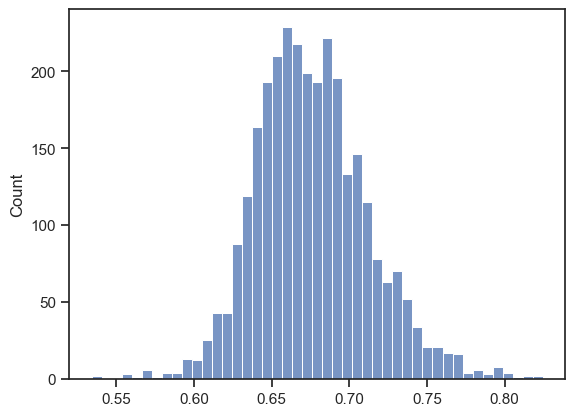

In [ ]:
result_list = get_model_performace(user_list=test_users)
sns.histplot(result_list)

In [ ]:
results_df = pd.DataFrame({"averge_similarity": result_list})

In [ ]:
results_df.to_parquet("entire_data_result.parquet")

# Other Plots

In [ ]:
all_prods = pd.read_parquet("entire_data_train_test_result.parquet")
all_prods["product type"] = "All Products"

makeup = pd.read_parquet("makeup_train_test_result.parquet")
makeup["product type"] = "Makeup"

lip = pd.read_parquet("lipstick_train_test_result.parquet")
lip["product type"] = "Lip Stick"


In [ ]:
combined_data = pd.concat([lip, makeup, all_prods])

In [ ]:
combined_data.rename(columns={"averge_similarity": "Average Similarity", "product type": "Product Type"}, inplace=True)

Text(0.5, 1.0, 'Average Cosine Similarity of Train Data and Test Data')

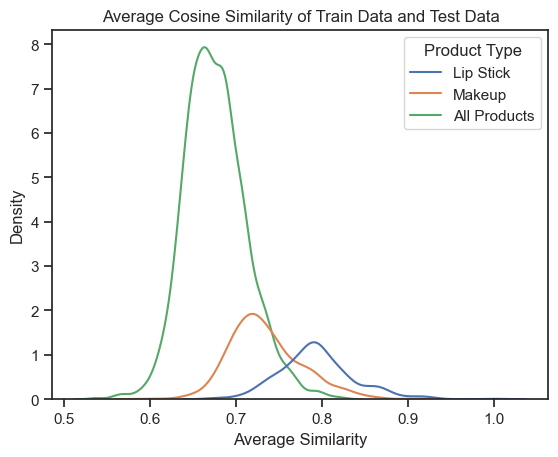

In [ ]:
ax = sns.kdeplot(data=combined_data, x="Average Similarity", hue="Product Type")
ax.set_title("Average Cosine Similarity of Train Data and Test Data")

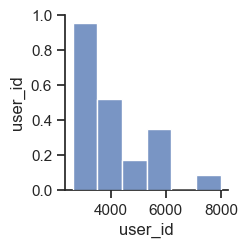

In [ ]:
sns.pairplot(out)

In [ ]:
d = pd.concat([train_df, test_df])

In [ ]:
d["product_type"] = ""
d["product_type 1"] = ""

In [ ]:
d["Hair Care"]["product_type"] = "Hair Care"
d["Skin Care"]["product_type"] = "Skin Care"
d[d["Makeup"]==1]["product_type"] = "Makeup"
d[d["Moisturizer"]==1]["product_type 1"] = "Moisturizer"
d[(d["Makeup"]==1) & (d["Lips"]==1)]["product_type 1"] = "Lipstick"

/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/407882479.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  d["Hair Care"]["product_type"] = "Hair Care"
/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/407882

In [ ]:
d[(d["Makeup"]==1) & (d["Lips"]==1)]["product_type 1"] = "Lipstick"

/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/2185832846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[(d["Makeup"]==1) & (d["Lips"]==1)]["product_type 1"] = "Lipstick"


In [ ]:
d["month"] = d["date"].apply(lambda x: "-".join(x.split("-")[:-1]))
d["year"] = d["date"].apply(lambda x: x.split()[0])


In [260]:
d1 = d[d["Hair Care"]==1]
d2 = d[d["Skin Care"]==1]
d3 = d[d["Makeup"]==1]
d4 = d[d["Moisturizer"]==1]
d5 = d[(d["Makeup"]==1) & (d["Lips"]==1)]

In [261]:
d1["Product Type"] = "Hair Care"
d2["Product Type"] = "Skin Care"
d3["Product Type"] = "Makeup"
d4["Product Type"] = "Moisturizer"
d5["Product Type"] = "Lipstick"


/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/1340148183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1["Product Type"] = "Hair Care"
/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/1340148183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["Product Type"] = "Skin Care"
/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/1340148183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [271]:
user_d1 = d1.groupby("month")["user_id"].nunique().reset_index().rename(columns={"user_id":"User Count"})
review_d1 = d1.groupby("month")["user_id"].count().reset_index().rename(columns={"user_id":"# Reviews"})
g_d1 = user_d1.merge(review_d1, how="inner", on="month")
g_d1["Product Type"] = "Hair Care"

user_d2 = d2.groupby("month")["user_id"].nunique().reset_index().rename(columns={"user_id":"User Count"})
review_d2 = d2.groupby("month")["user_id"].count().reset_index().rename(columns={"user_id":"# Reviews"})
g_d2 = user_d2.merge(review_d2, how="inner", on="month")
g_d2["Product Type"] = "Skin Care"

user_d3 = d3.groupby("month")["user_id"].nunique().reset_index().rename(columns={"user_id":"User Count"})
review_d3 = d3.groupby("month")["user_id"].count().reset_index().rename(columns={"user_id":"# Reviews"})
g_d3 = user_d3.merge(review_d3, how="inner", on="month")
g_d3["Product Type"] = "Makeup"

user_d4 = d4.groupby("month")["user_id"].nunique().reset_index().rename(columns={"user_id":"User Count"})
review_d4 = d4.groupby("month")["user_id"].count().reset_index().rename(columns={"user_id":"# Reviews"})
g_d4 = user_d4.merge(review_d4, how="inner", on="month")
g_d4["Product Type"] = "Moisturizer"

user_d5 = d5.groupby("month")["user_id"].nunique().reset_index().rename(columns={"user_id":"User Count"})
review_d5 = d5.groupby("month")["user_id"].count().reset_index().rename(columns={"user_id":"# Reviews"})
g_d5 = user_d5.merge(review_d5, how="inner", on="month")
g_d5["Product Type"] = "Lipstick"

In [295]:
g_d = pd.concat([g_d1.head(24), g_d2.head(24), g_d3.head(24), g_d4.head(24), g_d5.head(24)])

/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/1931224417.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.figure.legend()


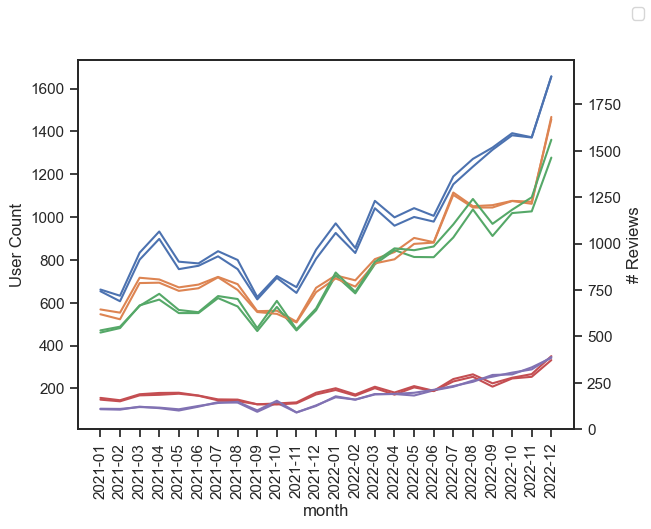

In [304]:
ax = sns.lineplot(data=g_d, x="month", y="User Count", hue="Product Type", legend=False)
# ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax2 = ax.twinx()
sns.lineplot(data=g_d, x="month", y="# Reviews", hue="Product Type", ax=ax2, legend=False)
ax.figure.legend()
ax.tick_params(axis='x', labelrotation=90)
plt.show()

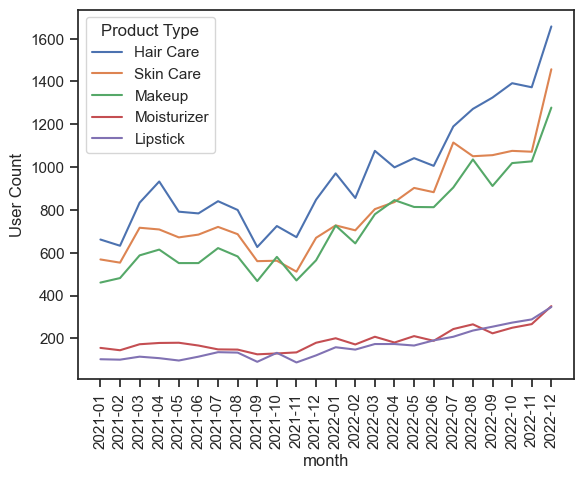

In [316]:
ax = sns.lineplot(data=g_d,x="month", y="User Count", hue="Product Type",)
# ax = g.plot(sns.lineplot, sns.histplot)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [323]:
g_da = g_d[["month", "User Count", "Product Type"]].rename(columns={"User Count": "value"})
g_da["Metric"] = "User Count"

g_db = g_d[["month", "# Reviews", "Product Type"]].rename(columns={"# Reviews": "value"})
g_db["Metric"] = "# Reviews"

g_dz = pd.concat([g_da, g_db])

In [331]:
g_dz["month"].replace({
    "2021-01": "Jan 2021",
    "2021-02": "Feb 2021",
    "2021-03": "Mar 2021",
    "2021-04": "Apr 2021",
    "2021-05": "May 2021",
    "2021-06": "Jun 2021",
    "2021-07": "Jul 2021",
    "2021-08": "Aug 2021",
    "2021-09": "Sep 2021",
    "2021-10": "Oct 2021",
    "2021-11": "Nov 2021",
    "2021-12": "Dec 2021",
    "2022-01": "Jan 2022",
    "2022-02": "Feb 2022",
    "2022-03": "Mar 2022",
    "2022-04": "Apr 2022",
    "2022-05": "May 2022",
    "2022-06": "Jun 2022",
    "2022-07": "Jul 2022",
    "2022-08": "Aug 2022",
    "2022-09": "Sep 2022",
    "2022-10": "Oct 2022",
    "2022-11": "Nov 2022",
    "2022-12": "Dec 2022",
}, inplace=True)

/var/folders/1n/0vbkzl6j51vfpgzy8_xndtxh0000gn/T/ipykernel_9016/1131383505.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  g_dz["month"].replace({


/Users/abhishek/.pyenv/versions/3.12.0/envs/py312_project/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


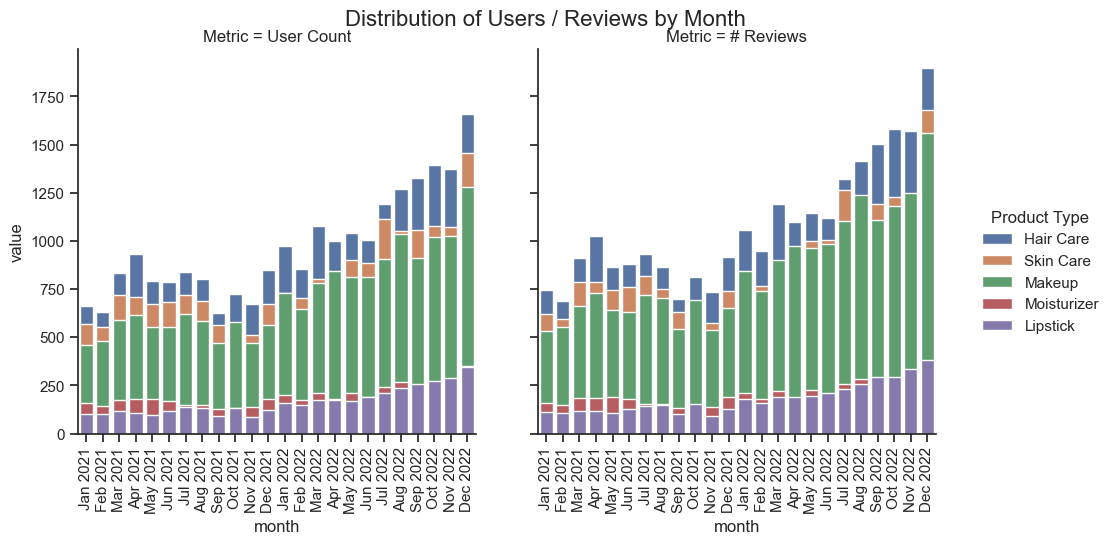

In [336]:
g = sns.FacetGrid(g_dz, col="Metric", hue="Product Type", margin_titles=True, height=5)
g.map(sns.barplot, "month", "value",)
g.add_legend()
g.tick_params(axis='x', labelrotation=90)
g.fig.suptitle("Distribution of Users / Reviews by Month", fontsize=16)

# Adjust layout to make room for the title
g.fig.subplots_adjust(top=0.9)

plt.show()

# g.set_titles(["Number of Users Per Month", "Number of Reviews Per Month"])